-------
# Dataset Loading

In [1]:
# Setting up google drive 
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# import sys
# sys.path.append('/content/drive/My Drive/Colab Notebooks')

In [2]:
import torch
from torch import nn
from IPython import display
import my_utils as mu

In [3]:
from torchvision import datasets 
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

batch_size = 256

transform_1 = transforms.Compose([
    transforms.ToTensor(),
])

cifar_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_1)
cifar_testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_1)

trainDL = DataLoader(cifar_trainset, batch_size, shuffle=True)
testDL = DataLoader(cifar_testset, batch_size, shuffle=True)

# print(cifar_trainset)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
print(next(iter(trainDL))[0].shape)

torch.Size([256, 3, 32, 32])


------
# Model & Weight Initialisation

In [35]:
class KKNet(torch.nn.Module):
    def __init__(self, num_inputs=3*32*32, num_channels=3, num_outputs=10, num_hidden=[2, 3, 2]):
        super(KKNet, self).__init__()
        
        self.num_inputs, self.num_channels, self.num_outputs, self.num_hidden = num_inputs, num_channels, num_outputs, num_hidden

        self.relu = nn.Sigmoid()

        #### Backbone 1

        self.a1 = nn.AvgPool2d(3)
        self.l1 = nn.Linear(3*10*10, self.num_hidden[0])

        self.conv1 = nn.Conv2d(3, 16, kernel_size = 3)

        #### Backbone 2

        self.a2 = nn.AvgPool2d(2)
        self.l2 = nn.Linear(16*15*15, self.num_hidden[1])

        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3)

        #### Backbone 3

        self.a3 = nn.AvgPool2d(2)
        self.l3 = nn.Linear(32*14*14, self.num_hidden[2])

        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3)

        ##### Classifier

        self.ac = nn.AvgPool2d(2)

        self.f = nn.Flatten()

        self.lc1 = nn.Linear(6272, 2048)
        self.lc2 = nn.Linear(2048, 550)
        self.lc3 = nn.Linear(550, 350)
        self.lc4 = nn.Linear(350, 120)
        self.lc5 = nn.Linear(120, self.num_outputs)
    
    def backbone_block():
        return nn.Sequential(
          nn.Conv2d(1,20,5),
          nn.ReLU(),
          nn.Conv2d(20,64,5),
          nn.ReLU()
        )
    
    def forward(self, x):
        #### Backbone 1

        out11 = self.a1(x)
        out11 = out11.view(-1,3*10*10)
        out11 = self.l1(out11)
        out11 = self.relu(out11)
        out11 = out11.view(-1,self.num_hidden[0],1,1,1)

        conv_outputs = []
        for _ in range(self.num_hidden[0]):
            o = self.conv1(x)
#             o = self.relu(o)
            conv_outputs.append(o)
        out12 = torch.stack(conv_outputs, dim=1)
        out32 = self.relu(out32)

        out12 = out11*out12

        out1 = out12.sum(dim=1)

        #### Backbone 2

        out21 = self.a2( out1 )
        out21 = out21.view(-1,16*15*15)
        out21 = self.l2(out21)
        out21 = self.relu(out21)
        out21 = out21.view(-1,self.num_hidden[1],1,1,1)
        conv_outputs = []
        for _ in range(self.num_hidden[1]):
            o = self.conv2( out1 )
#             o = self.relu(o)
            conv_outputs.append(o)
        out22 = torch.stack(conv_outputs, dim=1)
        out22 = self.relu(out22)

        out22 = out21*out22

        out2 = out22.sum(dim=1)

        #### Backbone 3
        
        out31 = self.a3( out2 )
        out31 = out31.view(-1,32*14*14)
        out31 = self.l3(out31)
        out31 = self.relu(out31)
        out31 = out31.view(-1,self.num_hidden[2],1,1,1)

        conv_outputs = []
        for _ in range(self.num_hidden[2]):
            o = self.conv3( out2 )
#             o = self.relu(o)
            conv_outputs.append(o)
        out32 = torch.stack(conv_outputs, dim=1)
        out32 = self.relu(out32)

        out32 = out31*out32

        out3 = out32.sum(dim=1)

        
        ##### Classifier

        outC = out2
        outC = self.ac(outC)

        outC = self.f(outC)
        # print("C", outC.shape)
        outC = self.lc1(outC)
        outC = self.relu(outC)
        outC = self.lc2(outC)
        outC = self.relu(outC)
        outC = self.lc3(outC)
        outC = self.relu(outC)
        outC = self.lc4(outC)
        outC = self.relu(outC)
        outC = self.lc5(outC)

        return outC
    
# Check Model
inp = torch.rand(256,3,32,32)
model = KKNet()
model.apply(init_weights)
a = model.forward(inp)
print("Valid")

Valid


In [5]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking thr type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)          

In [36]:
debug = False
input_channels = 3
num_outputs = 10
modelKK = KKNet()

modelKK.apply(init_weights);
print(modelKK)

loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(modelKK.parameters(), lr=lr)

KKNet(
  (relu): Sigmoid()
  (a1): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (l1): Linear(in_features=300, out_features=2, bias=True)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (a2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (l2): Linear(in_features=3600, out_features=3, bias=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (a3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (l3): Linear(in_features=6272, out_features=2, bias=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (ac): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (f): Flatten(start_dim=1, end_dim=-1)
  (lc1): Linear(in_features=6272, out_features=2048, bias=True)
  (lc2): Linear(in_features=2048, out_features=550, bias=True)
  (lc3): Linear(in_features=550, out_features=350, bias=True)
  (lc4): Linear(in_features=350, out_features=120, bias=True)
  (lc5): Linear(in_features=120, out_features=10, bias=True)
)


AssertionError: 1.3490457472991944

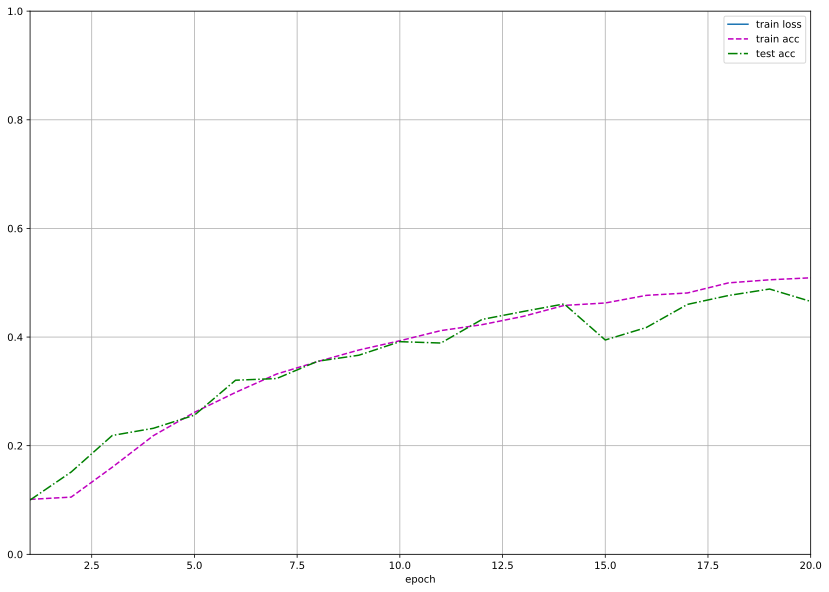

In [37]:
num_epochs = 20
mu.train_ch3(modelKK, trainDL, testDL, loss, num_epochs, optimizer)

In [7]:
debug = True
x3,y3 = next(iter(trainDL))

num_inputs = 3*32*32
num_outputs = 10
num_channels = 3

# x3,y3 = next(iter(train_iter))
# print(x3.size(), y3.size())

# print(inp.dtype)
# print(inp.shape)

num_inputs = 3
# model = Net(num_inputs, num_outputs)
model = KKNet()


# model = Net(num_inputs, num_channels, num_outputs)

model.apply(init_weights)

a = model.forward(inp)

print(a.shape)


torch.Size([256, 10])


In [ ]:
class LeNet1(torch.nn.Module):
    def __init__(self, num_inputs=3, num_outputs=10):
        super(LeNet1, self).__init__()
        # self.num_inputs = num_inputs
        # self.num_outputs = num_outputs

        self.Convl1 = nn.Conv2d(num_inputs, 6, kernel_size = 5)
        self.relu = nn.ReLU()
        self.Avg1 = nn.AvgPool2d(2, stride=2)
        self.Convl2 = nn.Conv2d(6,16,kernel_size = 5)
        self.Avg2 = nn.AvgPool2d(2, stride=2)
        self.Fltn = nn.Flatten()
        self.Linear1 = nn.Linear(400, 120)
        self.Linear2 = nn.Linear(120, 84)
        self.Linear3 = nn.Linear(84, num_outputs)
    def forward(self, x):
        out = self.Convl1(x)
        out = self.relu(out)
        out = self.Avg1(out)
        out = self.Convl2(out)
        out = self.relu(out)
        out = self.Avg2(out)
        #out = self.relu(out)
        out = self.Fltn(out)
        # print(out.shape)
        out = self.Linear1(out)
        out = self.relu(out)
        out = self.Linear2(out)
        out = self.relu(out)
        out = self.Linear3(out)
        # out = self.relu(out)
        return out

In [ ]:
# debug = False
input_channels = 3
num_outputs = 10
modelKK = LeNet1()

modelL1.apply(init_weights);
print(modelL1)

loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(modelL1.parameters(), lr=lr)

num_epochs = 20
mu.train_ch3(modelL1, trainDL, testDL, loss, num_epochs, optimizer)

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.avgpool1(torch.relu(self.conv1(x)))
        x = self.avgpool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking thr type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)          

input_channels = 3
num_outputs = 10
model = LeNet()

model.apply(init_weights);
print(model)

----------
# Loss Function & optimizer

In [ ]:
loss = nn.CrossEntropyLoss()
lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

----------
# Training

In [ ]:
debug = False

num_epochs = 20
mu.train_ch3(model, trainDL, testDL, loss, num_epochs, optimizer)

----------
# Evaluation

--------
# Scratch Testing

## Shape testing

## Deployemnt test

In [ ]:
# !pip install init
# import tarfile, pickle
# # from init import *
# from google.colab import drive

# drive.mount('/content/drive/')

# tar_file = tarfile.open("/content/drive/My Drive/cifar-10-python.tar.gz", 'r:gz')

In [ ]:
# testX2= torch.from_numpy(testX[0:, :, :, :]).to(torch.float32)
# testy2 = torch.from_numpy(testy[0:]).to(torch.int64)

# print(testy2.size())

# testDS2 = TensorDataset(testX2,testy2)
# testDL2 = DataLoader(testDS2) 

# iter_a = iter(testDL2)

# t = 0
# x = 0

# for _ in range(9500):

#   X_test, y_test = next(iter_a)
#   op = net.forward(X_test)

#   _, y_hat = op.max(1)
  
#   a = y_hat[0] == y_test[0][0]
#   t = t+1

#   if a:
#     x = x+1

# print(t, x)

## Alternate Dataset loading

In [ ]:
# from matplotlib import pyplot
# from keras.datasets import cifar10
# # load dataset
# (trainX, trainy), (testX, testy) = cifar10.load_data()
# # trainX = trainX.transpose(0,1)
# # testX = testX.transpose(1,3)
# # summarize loaded dataset
# print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
# print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# # plot first few images

# for i in range(9):
#     pyplot.subplot(330 + 1 + i)
#     pyplot.imshow(trainX[i])

# pyplot.show()

In [ ]:
# # print(trainX)
# trainX1 = torch.from_numpy(trainX[0:, :, :, :]).to(torch.float32)
# trainy1 = torch.from_numpy(trainy[0:]).to(torch.int64)
# trainy1 = trainy1.T[0]
# testX1 = torch.from_numpy(testX[0:, :, :, :]).to(torch.float32)
# testy1 = torch.from_numpy(testy[0:]).to(torch.int64)

# print(trainX1.size())
# print(trainy1)

In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# batch_size = 256

# trainDS = TensorDataset(trainX1,trainy1) # create your datset
# testDS = TensorDataset(testX1,testy1) # create your datset
# trainDL = DataLoader(trainDS, batch_size=batch_size) # create your dataloader
# testDL = DataLoader(testDS, batch_size=batch_size) # create your dataloader

In [ ]:
# X, y = next(iter(trainDL))
# print(X.size())
# print(y)